# PHYS-GA2059 - Statistics and Data Science for Physicists
# Student: Gehan Ranepura
## Problem Set #3 - Problem 1 - (DataPts 5 - 20)
Go back to problem 1 of Problem Set 1. 

Hogg et al. (2010). Data analysis recipes: Fitting a model to data.
https://doi.org/10.48550/arXiv.1008.4686

- Using the standard linear algebra method of this Section, fit the straight line y = mx + b to the x, y, and $\sigma_y$ values for data points 5 through 20 in Table 1 on page 6.
  That is, ignore the first four data points, and also ignore the columns for $σ_x$ and $ρ_{xy}$. Make a plot showing the points, their uncertainties, and the best-fit line. Your plot should end up looking like Figure 1. What is the standard uncertainty variance $σ_m^2$ on the slope of the line?


Plot the best-fit slope m and intercept b, along with the one-sigma uncertainty ellipse implied by the standard error (covariance matrix) for this linear fitting problem. Then, for comparison, plot the same for problem 2 of Problem Set 1. Comments?

In [1]:
import sys
import pandas as pd
import numpy as np
import ipywidgets as widgets
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt

from numpy.linalg import inv
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from pylab import cm

''' Set up Plot Style ''' 

# plt.style.use(['science','nature'])
plt.style.use('classic')
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.which'] = 'both'
mpl.rcParams['xtick.minor.visible'] = True

## use (4,3) for 2 column plots, (8,6) for single plots.
fgsz_1 = (8,6)
fgsz_2 = (4,3)

In [2]:
data_file = np.loadtxt("data.txt", dtype=float)
data = data_file[4:,0:3]
print(data)

#  Read data file at path 'file_path'. Return a np array data = array(...).
#  Read data to ignore the first 5 data points

[[203. 495.  21.]
 [ 58. 173.  15.]
 [210. 479.  27.]
 [202. 504.  14.]
 [198. 510.  30.]
 [158. 416.  16.]
 [165. 393.  14.]
 [201. 442.  25.]
 [157. 317.  52.]
 [131. 311.  16.]
 [166. 400.  34.]
 [160. 337.  31.]
 [186. 423.  42.]
 [125. 334.  26.]
 [218. 533.  16.]
 [146. 344.  22.]]


# Standard weighted least-square fit

The total squared error, scaled by the uncertainties ($\chi^2$), is given by
$$\chi^2=\sum_{i=1}^N \frac{\left[y_i-f\left(x_i\right)\right]^2}{\sigma_{y i}^{2}} \equiv[\boldsymbol{Y}-\boldsymbol{X} \boldsymbol{\Theta}]^{\top} \boldsymbol{C}^{-1}[\boldsymbol{Y}-\boldsymbol{X} \boldsymbol{\Theta}]$$  

where, 
$$ f\left(x_i\right) = m x_i + b $$ 

The linear weighted least-square fit $\Theta = (m,b)$ is solved to be:
$$\hat{\mathbb{  \Theta }} = 
\left[\begin{array}{c}
\hat{m}  \\
\hat{b} 
\end{array}\right] =
\text{argmin}_{m,b} \{\chi^2\}= \left[\boldsymbol{X}^{\top} \boldsymbol{C}^{-1} \boldsymbol{X}\right]^{-1}\left[\boldsymbol{X}^{\top} \boldsymbol{C}^{-1} \boldsymbol{Y}\right]$$

where, the matrix dimensions are
$$ \hat{\mathbb{  \Theta }} \rightarrow \boldsymbol{ [ (2 x n) * (n x n) * (n x 2) ]  ^ {-1} * [ (2 x n) * (n x n) * (n x 1) ] } $$

$$ \hat{\mathbb{  \Theta }} \rightarrow \boldsymbol{ (2 x 2) * (2 x 1) } $$

$$ \hat{\mathbb{  \Theta }} \rightarrow \boldsymbol{ (2 x 1) } $$

## Build Matrices

In [3]:
# Row Vectors of data
xs = data[:,0]
ys = data[:,1]
sigs = data[:,2]

# Column Vectors for Matrices
xs = xs[..., None] 
num_rows, num_cols = xs.shape
X0 = np.ones((num_rows,1))
X = np.hstack((xs,X0))
Y = ys[..., None] 

# Create covariance Matrix
sigs_inv2 = sigs**-2
Cinv = np.diag(sigs_inv2)

#print("Cinv {}".format(Cinv))

# Solve Matrix Multiplication Equation
A = X.T @ Cinv @ X
B = X.T @ Cinv @ Y
theta = np.linalg.solve(A, B)

m = float(theta[0][0])
b = float(theta[1][0])

The uncertainty in parameters $m,b$ is given by 
$ [ \boldsymbol{X}^{\top} \boldsymbol{C}^{-1} \boldsymbol{X} ]^{-1} $.

Explicitly,

$$
[ \boldsymbol{X}^{\top} \boldsymbol{C}^{-1} \boldsymbol{X} ]^{-1} = 
\left[\begin{array}{cc}
\sigma_m^2 & \sigma_{m,b} \\
\sigma_{m,b} & \sigma_b^2 
\end{array}\right]
$$

Or,
$$ \sigma_m = \sqrt{\frac{A_{22} }{A_{11} A_{22} - A_{12} ^2}}, \sigma_b = \sqrt{\frac{A_{11} }{A_{11} A_{22} - A_{12} ^2}} $$
 

In [4]:
# Solve Uncertainties
invA  = np.linalg.inv(A)
m_sig = np.sqrt(invA[0][0])
b_sig = np.sqrt(invA[1][1])

A11 = float(A[0][0])
A12 = float(A[0][1])
A22 = float(A[1][1])

m_sig2 = np.sqrt((A22)/(A11 * A22 - A12 * A12) )
b_sig2 = np.sqrt((A11)/(A11 * A22 - A12 * A12) )

m_res =  "%s \pm %s"%(round(m,2),round(m_sig,2))
b_res =  "%s \pm %s"%(round(b,2),round(b_sig,2))

print(m_res)
print(b_res)

2.24 \pm 0.11
34.05 \pm 18.25


In [5]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    
    x = [i[0] for i in data]
    y = [i[1] for i in data]
    
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

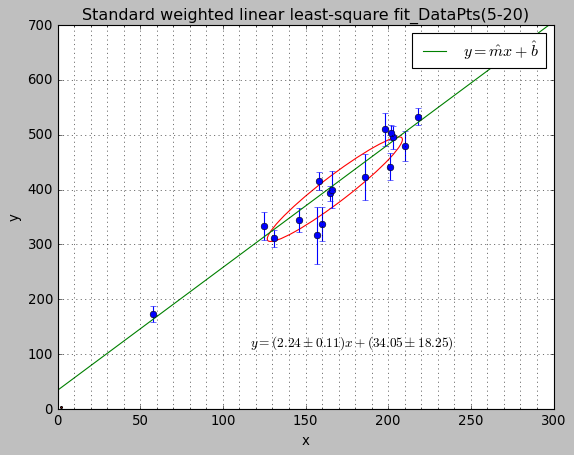

<Figure size 640x480 with 0 Axes>

In [6]:
#%matplotlib widget
#from IPython import get_ipython
#get_ipython().run_line_magic('matplotlib', 'inline')

fig, ax = plt.subplots(figsize=fgsz_1)
ax.set_xlim([0, 300])
ax.set_ylim([0, 700])
ax.set_xlabel('x')
ax.set_ylabel('y')

xx = np.linspace(0,300,400)
ax.errorbar(xs , ys, yerr = sigs, fmt='o')  
ax.plot(xx , m * xx + b, label= '$y = \hat{m} x +\hat{b}$')
ax.set_title('Standard weighted linear least-square fit_DataPts(5-20)' )
ax.annotate("$y = (%s) x + (%s) $"%(m_res,b_res), xy=(1, 1), xycoords='data', xytext=(0.8, 0.15), 
            textcoords='axes fraction',
            # arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',
            )

mu = 2, 4
scale = 3, 5
x = [i[0] for i in data]
y = [i[1] for i in data]
ax.scatter(x, y, s=0.5)
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
confidence_ellipse(x, y, ax, edgecolor='red')
ax.scatter(mu[0], mu[1], c='red', s=3)


plt.legend()
plt.show()
plt.savefig('plot_point_DataPts(5-20).png', transparent=False, bbox_inches='tight')